In [1]:
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

idx = pd.IndexSlice

sys.path.append(str(
    Path.cwd().parent / 'scripts'
))

from summarize_system_cost import (
    get_wholesale_cost,
    get_congestion_rents,
    get_cfd_payments,
    get_roc_cost,
    get_balancing_cost,
    get_bidding_volume
)


In [2]:
bmus = pd.read_csv(
    Path.cwd().parent /
    'data' /
    'preprocessed' /
    'prepared_bmus.csv',
    index_col=0
    )
plants = bmus.loc[bmus.carrier.str.contains('wind')].index

In [3]:
cfd_strike_prices = pd.read_csv(
    Path.cwd().parent / 'data' / 'preprocessed' / 'cfd_strike_prices.csv',
    index_col=0,
    parse_dates=True
    )

roc_values = pd.read_csv(
    Path.cwd().parent / 'data' / 'preprocessed' / 'roc_values.csv',
    index_col=0
    ).iloc[:,0]

In [4]:
path = Path.cwd().parent / 'data' / 'base'
day_range = pd.date_range(start='2024-03-01', end='2024-03-31', freq='D')

bids = []

for day in day_range:
    bids.append(pd.read_csv(
        path / day.strftime('%Y-%m-%d') / 'bids.csv',
        index_col=[0,1], 
        parse_dates=True,
        ))

bids = pd.concat(bids)
bids = bids[plants.intersection(bids.columns)]
bids = bids.loc[idx[:,'vol'], :]
bids.index = bids.index.get_level_values(0)

<Axes: >

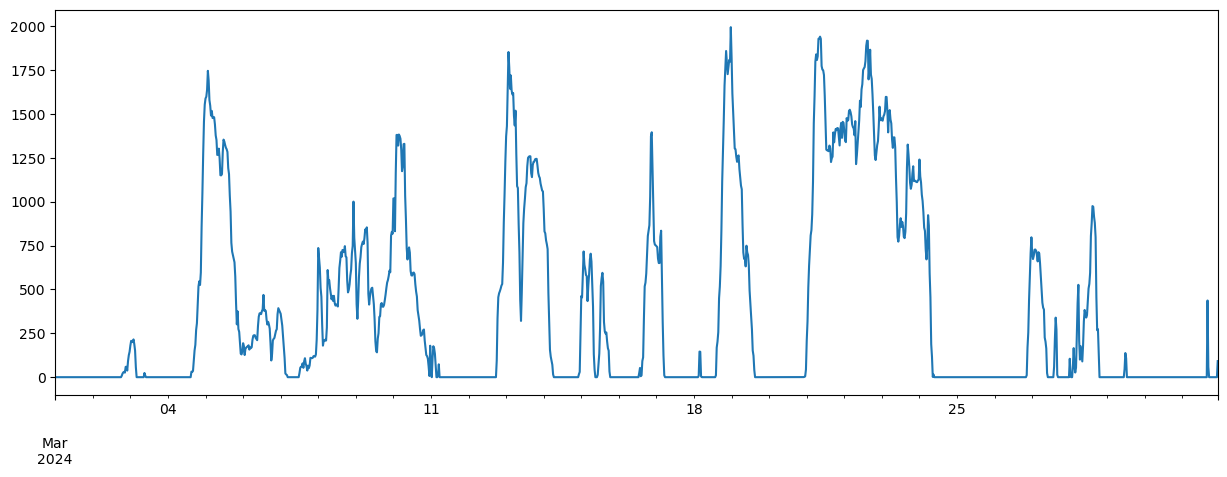

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

bids.replace(np.nan, 0).sum(axis=1).plot(ax=ax)

In [ ]:
bids_day = pd.read_csv(
        path / nat.snapshots[4].strftime('%Y-%m-%d') / 'bids.csv',
        index_col=[0,1], 
        parse_dates=True,
        )
offers_day = pd.read_csv(
        path / nat.snapshots[4].strftime('%Y-%m-%d') / 'offers.csv',
        index_col=[0,1], 
        parse_dates=True,
        )

bidcosts, offercosts = get_balancing_cost(nat, bal, bids_day, offers_day)

In [8]:
day = '2024-03-22'
mode = 'static'

def get_networks(day, mode):

    nod = pypsa.Network(
        Path.cwd().parent /
        'results' /
        f'{day}' /
        f'network_{mode}_s_nodal_solved.nc'
    )

    nat = pypsa.Network(
        Path.cwd().parent /
        'results' /
        f'{day}' /
        f'network_{mode}_s_national_solved.nc'
    )

    bal = pypsa.Network(
        Path.cwd().parent /
        'results' /
        f'{day}' /
        f'network_{mode}_s_national_solved_redispatch.nc'
    )

    return nod, nat, bal

In [55]:
congestion_rent_compensation_share = 0.5

total_national_costs = pd.DataFrame(
    {
        'wholesale': get_wholesale_cost(nat).values,
        'congestion_rent': get_congestion_rents(nat).values * congestion_rent_compensation_share,
        'cfd_payments': get_cfd_payments(nat, cfd_strike_prices).values,
        'roc_payments': get_roc_cost(bal, roc_values).values,
        'offer_cost': offercosts.values,
        'bid_cost': bidcosts.values,
    },
    index=nat.snapshots
).mul(1e-6)# .sum()

total_nodal_costs = pd.DataFrame(
    {
        'wholesale': get_wholesale_cost(nod).values,
        'congestion_rent': - get_congestion_rents(nod).values * congestion_rent_compensation_share,
        'cfd_payments': get_cfd_payments(nod, cfd_strike_prices).values,
        'roc_payments': get_roc_cost(nod, roc_values).values,
        'offer_cost': 0,
        'bid_cost': 0,
    },
    index=nat.snapshots
).mul(1e-6)# .sum()

In [9]:

nice_names = {
    'wholesale': 'Wholesale Market',
    'roc_payments': 'Renewable Obligation Certificates',
    'cfd_payments': 'Contracts for Differences',
    'congestion_rent': 'Intra-GB Congestion Rents',
    'offer_cost': 'Redispatch - Offers',
    'bid_cost': 'Redispatch - Bids',
}

color_dict = {
    'wholesale': '#F78C6B',
    'roc_payments': '#EF476F',
    'cfd_payments': '#06D6A0',
    'congestion_rent': '#FFD166',
    'offer_cost': '#073B4C',
    'bid_cost': '#118AB2',
}


In [10]:
pd.concat((
    total_nodal_costs.stack().rename('nodal'),
    total_national_costs.stack().rename('national')
), axis=1)

NameError: name 'total_nodal_costs' is not defined

In [11]:
total_national_costs.sum().rename(total_national_costs.index[0].strftime('%Y-%m-%d'))

NameError: name 'total_national_costs' is not defined

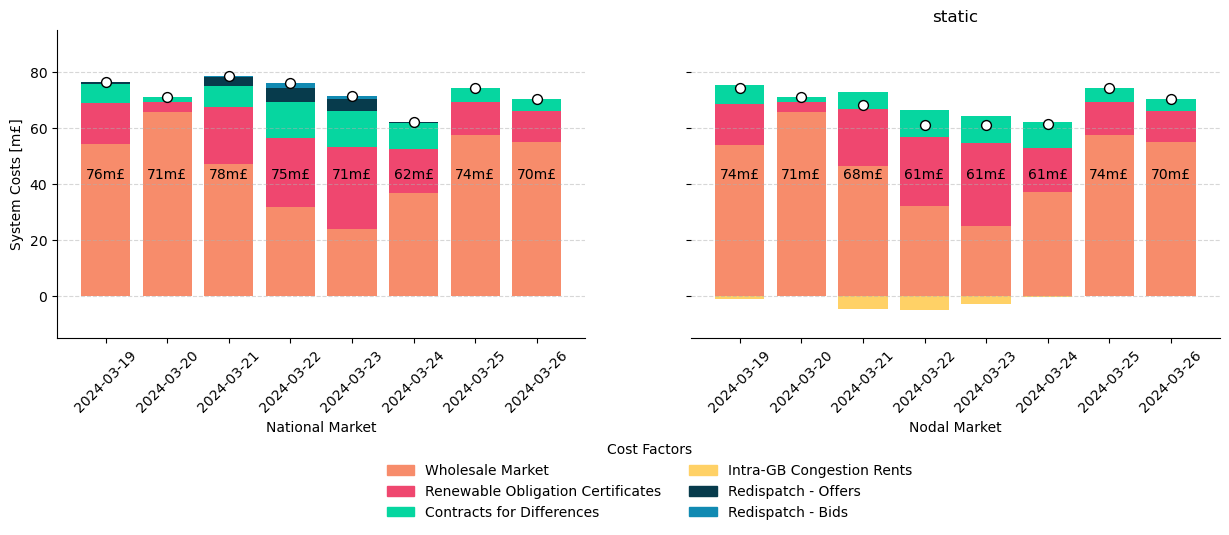

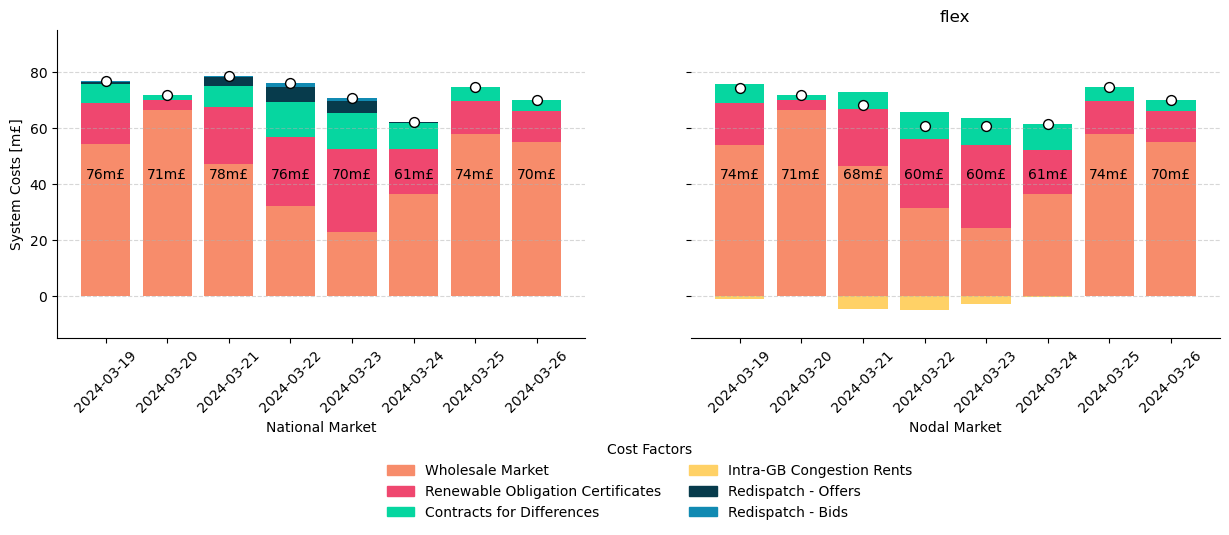

In [12]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.CRITICAL)

total_costs = {}


def stack_to_ax(df, ax):

    s = df.sum()

    total_costs[s.name] = s.sum()
    x_loc = df.index[4].strftime('%Y-%m-%d')

    pos = s.loc[s > 0]
    neg = s.loc[s < 0]

    pos_quants = [q for q in list(nice_names) if q in pos.index]
    neg_quants = [q for q in list(nice_names) if q in neg.index]

    pos = pos.loc[pos_quants]
    pos_bottom = [0] + pos.cumsum().tolist()[:-1]

    for (name, value), b in zip(pos.items(), pos_bottom):

        ax.bar(
            x_loc,
            bottom=b,
            height=value,
            label=nice_names[name],
            color=color_dict[name]
            )

    neg = neg.loc[neg_quants]
    neg_bottom = [0] + neg.cumsum().tolist()[:-1]

    for (name, value), b in zip(neg.items(), neg_bottom):
        # assert len(neg) == 1
        ax.bar(
            x_loc,
            bottom=0,
            height=value,
            label=nice_names[name],
            color=color_dict[name]
            )

    ax.text(
        x_loc, 42,
        '{}m£'.format(int(s.sum())),
        ha='center',
    )

    ax.scatter([x_loc], [s.sum()], color='w', zorder=10, edgecolor='k', s=50)

# for day in pd.date_range('2023-02-10', '2023-02-15', freq='D'):
for mode in ['static', 'flex']:

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    for day in pd.date_range('2024-03-19', '2024-03-26', freq='D'):

        data = pd.read_csv(
            Path.cwd().parent /
            'results' /
            f'{day.strftime("%Y-%m-%d")}' /
            f'system_cost_summary_{mode}.csv',
            index_col=[0,1],
            parse_dates=True)# .groupby(level=1).sum()
        
        total_national_costs = data['national'].unstack()
        total_nodal_costs = data['nodal'].unstack()

        stack_to_ax(total_national_costs, axs[0])
        stack_to_ax(total_nodal_costs, axs[1])

    for ax in axs:

        # ax.set_xticks([])
        ax.set_ylim(-15, 95)
        ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=-1)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        for tick in ax.get_xticklabels():
            tick.set_rotation(45)


    axs[1].spines['left'].set_visible(False)

    handles, labels = [], []

    for name, nice_name in nice_names.items():
        handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
        labels.append(nice_name)

    axs[0].set_xlabel('National Market')
    axs[1].set_xlabel('Nodal Market')

    axs[0].set_ylabel('System Costs [m£]')
    axs[1].set_yticklabels([])

    axs[0].legend(
        handles,
        labels,
        title='Cost Factors',
        loc='upper left',
        bbox_to_anchor=(0.6, -0.3),
        frameon=False,
        ncol=2
        )

    plt.title(mode)
    # plt.savefig('2024_cost_example.png', bbox_inches='tight', dpi=300)
    plt.show()

In [83]:
static = pd.read_csv(
    Path.cwd().parent / 'results' / '2024-03-22' / 'system_cost_summary_static.csv',
    index_col=[0,1],
).groupby(level=1).sum()
flex = pd.read_csv(
    Path.cwd().parent / 'results' / '2024-03-22' / 'system_cost_summary_flex.csv',
    index_col=[0,1],
).groupby(level=1).sum()

In [84]:
flex

,nodal,national
bid_cost,0.000000,1.623956
cfd_payments,9.773055,12.753650
congestion_rent,-5.163188,0.000000
offer_cost,0.000000,5.092902
roc_payments,24.696389,24.626175
wholesale,31.259786,31.917110


In [85]:
static

,nodal,national
bid_cost,0.000000,1.631334
cfd_payments,9.601410,12.763790
congestion_rent,-5.262119,0.000000
offer_cost,0.000000,5.094962
roc_payments,24.696389,24.624900
wholesale,32.004235,31.806039


In [77]:
nf = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_flex_s_national_solved.nc'
)
ns = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_static_s_national_solved.nc'
)

In [78]:
ic = ns.links.loc[ns.links.carrier == 'interconnector'].index

<Axes: xlabel='snapshot'>

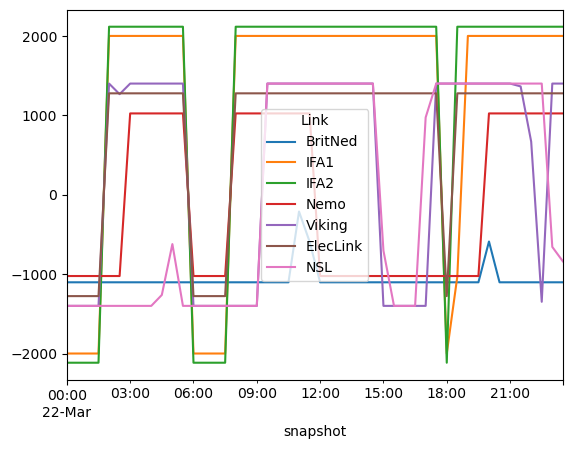

In [80]:
nf.links_t.p0.loc[:, ic].plot()

<Axes: xlabel='snapshot'>

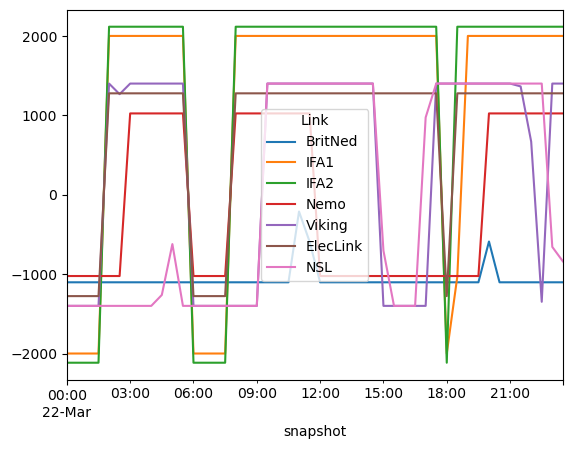

In [81]:
ns.links_t.p0.loc[:, ic].plot()

In [294]:
from tqdm import tqdm

bids = []
data_unavailable_count = 0
missing_days = []

dates = pd.date_range('2022-07-01', '2024-10-31', freq='D')

for day in tqdm(dates):
    try:
        bids.append(pd.read_csv(
            Path.cwd().parent / 'data' / 'base' / day.strftime('%Y-%m-%d') / 'bids.csv',
            index_col=[0,1], 
            parse_dates=True,
            ))
    except FileNotFoundError:
        data_unavailable_count += 1
        missing_days.append(day)

bids = pd.concat(bids).loc[idx[:,'vol'], :]

bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)
plants = bmus.loc[bmus.carrier.str.contains('wind')].index
bids = bids[plants.intersection(bids.columns)]
bids = bids.loc[idx[:,'vol'], :]
bids.index = bids.index.get_level_values(0)

100%|██████████| 854/854 [00:04<00:00, 181.66it/s]


In [325]:
total_bidding_vol = bids.fillna(0).sum(axis=1).mul(1e-3).sum() * len(dates) / (len(dates) - data_unavailable_count)

In [329]:
bids.fillna(0).sum(axis=1).mul(1e-3).sum()

9105.674230427017

In [ ]:
from tqdm import tqdm

idx = pd.IndexSlice

model_dates = (
    pd.date_range('2023-02-01', '2023-03-31', freq='D').tolist() +
    pd.date_range('2024-02-01', '2024-03-31', freq='D').tolist()
)

results = pd.DataFrame(
    np.nan,
    index=list(map(lambda dt: dt.strftime('%Y-%m-%d'), model_dates)),
    columns=['bidding_volume', 'national_cost', 'nodal_cost', 'nodal_cost_naive']
    )

for day in tqdm(model_dates):
    day = day.strftime('%Y-%m-%d')

    try:
        bvol = get_bidding_volume(day=day)
    except FileNotFoundError:
        continue

    results.loc[day, 'bidding_volume'] = bvol.sum()

    try:
        sc = pd.read_csv(
            Path.cwd().parent / 'results' / day / 'system_cost_summary.csv',
            index_col=[0,1],
            parse_dates=True
            )
    except FileNotFoundError:
        continue

    results.loc[day, 'national_cost'] = sc['national'].sum()
    results.loc[day, 'nodal_cost'] = sc['nodal'].sum()

    sc.loc[idx[:,'congestion_rent'], 'nodal'] *= 2
    results.loc[day, 'nodal_cost_naive'] = sc['nodal'].sum()

  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [01:14<00:00,  1.60it/s]


In [ ]:
# results['bidding_volume'].sum()
total_bidding_vol

11486.330565413107

In [343]:
r = results.copy()
r = r.dropna()

r['cost_difference'] = r['national_cost'] - r['nodal_cost']
r['cost_difference_naive'] = r['national_cost'] - r['nodal_cost_naive']


red = r['cost_difference'].sum()
red_naive = r['cost_difference_naive'].sum()

print('total estimated two year nodal cost reduction (m£)')
print(round(red / r['bidding_volume'].mul(1e-3).sum() * total_bidding_vol))

print('total estimated two year naive nodal cost reduction (m£)')
print(round(red_naive / r['bidding_volume'].mul(1e-3).sum() * total_bidding_vol))

total estimated two year nodal cost reduction (m£)
3361
total estimated two year naive nodal cost reduction (m£)
5162


<Axes: >

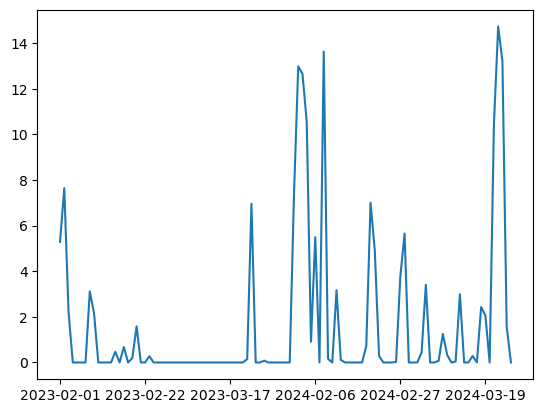

In [352]:
r['cost_difference'].plot()

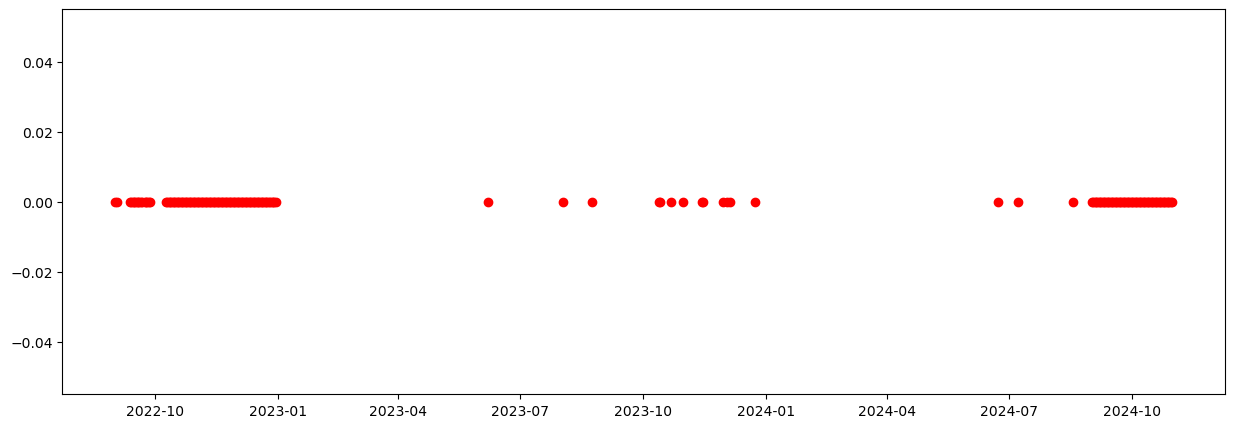

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(missing_days, [0]*len(missing_days), color='r', label='Missing Data')



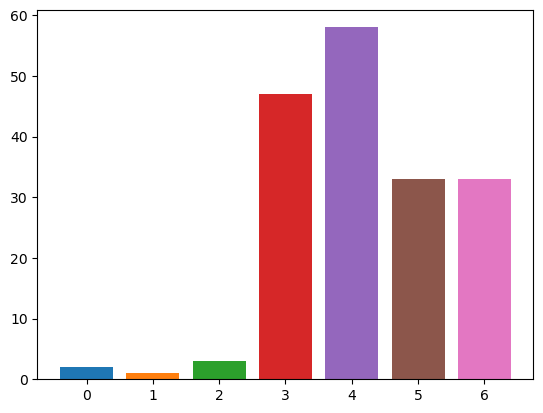

In [304]:
pretty = pd.to_datetime(missing_days).groupby(pd.to_datetime(missing_days).month)
for i, (month, days) in enumerate(pretty.items()):
    plt.bar(i, len(days), label=month)

In [293]:
bids

,CMSTW-1,ROTHW-1,PAUHW-1,CAIRW-2,MDHLW-1,TMNCW-1,ABRTW-1,ASHWW-1,ASLVW-1,BETHW-1,...,WTMSO-1,BEATO-2,THNTO-2,THNTO-1,GRGBW-1,GRGBW-2,GRGBW-3,SGRWO-1,ABRBO-1,OMNDO-1
2022-06-30 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30 23:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 20:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.975000,NaN,NaN
2024-08-31 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.983333,NaN,NaN
2024-08-31 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.975000,NaN,NaN
2024-08-31 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.975000,NaN,NaN


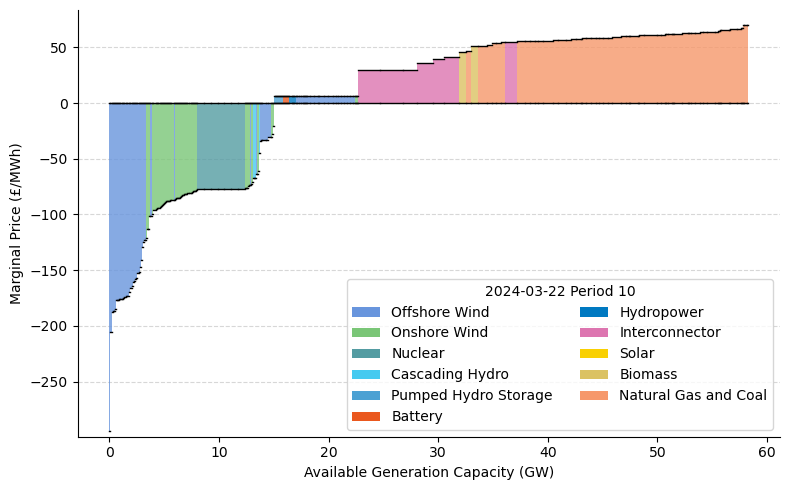

In [220]:
import sys
sys.path.append(str(Path.cwd().parent / 'scripts'))
from _plotting_helpers import plot_merit_order

plot_merit_order(nod, 10)

<Axes: xlabel='Bus'>

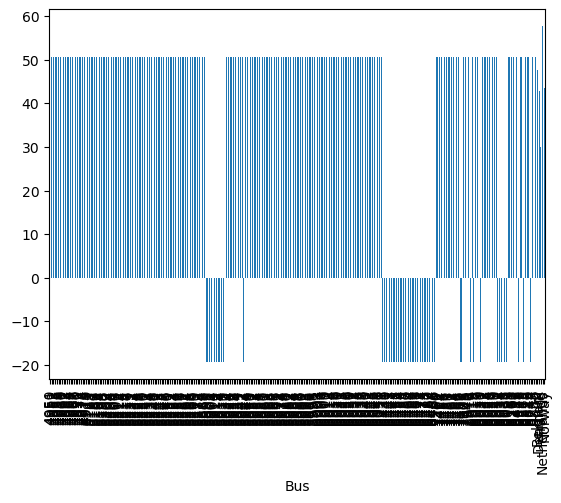

In [218]:
nod.buses_t.marginal_price.mean().plot.bar()

<Axes: xlabel='Bus'>

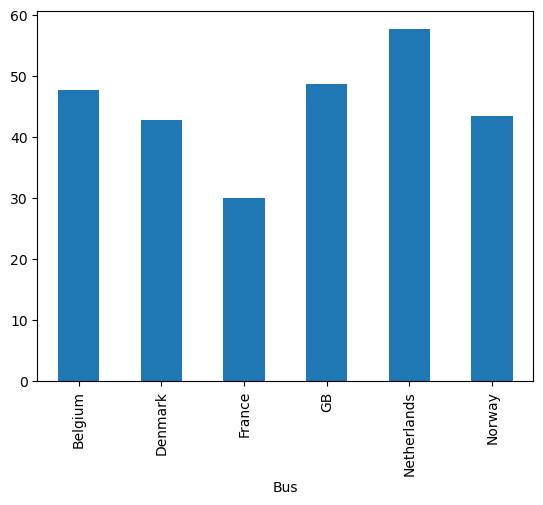

In [219]:
nat.buses_t.marginal_price.mean().plot.bar()

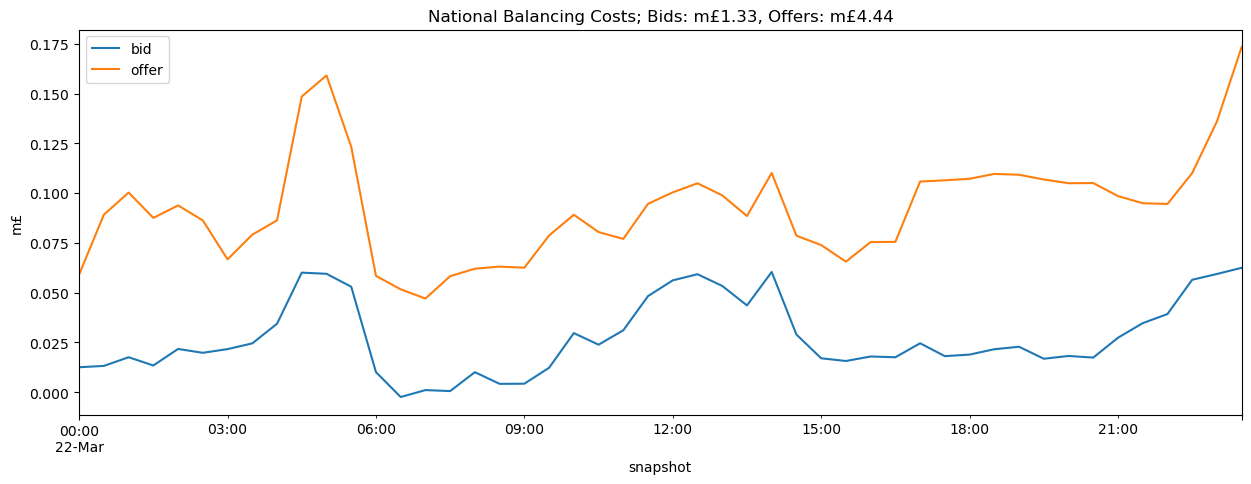

In [100]:
fig, ax = plt.subplots(figsize=(15, 5))

bidcosts.mul(1e-6).plot(ax=ax, label='bid')
offercosts.mul(1e-6).plot(ax=ax, label='offer')

ax.set_title(f'National Balancing Costs; Bids: m£{bidcosts.sum()*1e-6:.2f}, Offers: m£{offercosts.sum()*1e-6:.2f}')

ax.legend()
ax.set_ylabel('m£')

plt.show()

<Axes: ylabel='Frequency'>

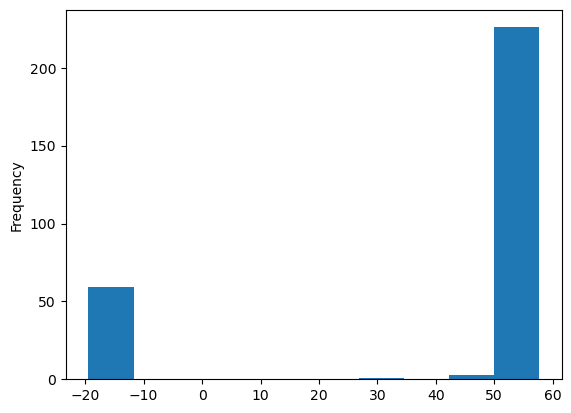

In [42]:
nod.buses_t.marginal_price.mean().plot.hist()

In [8]:
def set_nested_attr(obj, attr_path, value):
    """
    Sets a nested attribute on an object given an attribute path.

    Parameters:
    - obj: The object on which to set the attribute.
    - attr_path: A string representing the nested attribute path, e.g., 'a.b.c'.
    - value: The value to set for the nested attribute.
    """

    attrs = attr_path.split('.')

    for attr in attrs[:-1]:
        obj = getattr(obj, attr)

    setattr(obj, attrs[-1], value)


In [9]:
supplies = (
    pd.concat((
        nat
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Supply']
        .rename('national'),
        bal
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Supply']
        .rename('balanced'),
        nod
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Supply']
        .rename('nodal'),
    ), axis=1)
    # .drop(index=('Link', 'DC'))
    .drop(index=('Generator', 'local_market'))
    .groupby(level=1)
    .sum()
    .mul(1e-3)
)

withdraws = (
    pd.concat((
        nat
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Withdrawal']
        .rename('national'),
        bal
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Withdrawal']
        .rename('balanced'),
        nod
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Withdrawal']
        .rename('nodal'),
        ), axis=1)
    .drop(index=('Link', 'DC'))
    .drop(index=('Generator', 'local_market'))
    .groupby(level=1)
    .sum()
    .mul(-1e-3)
)

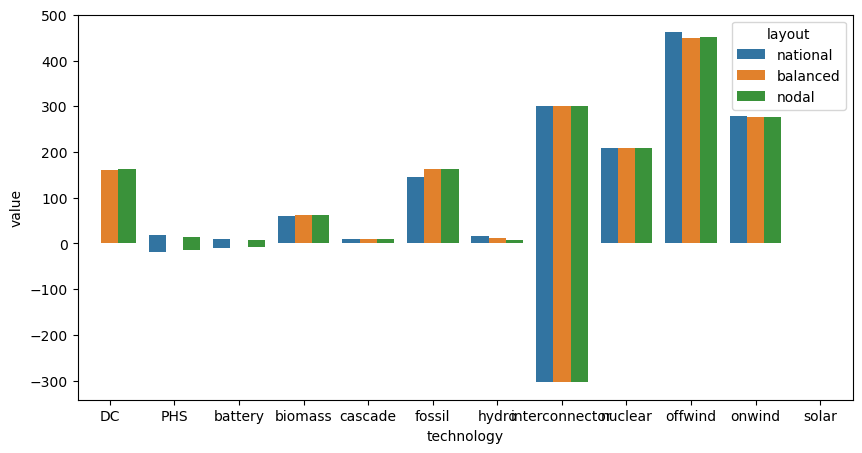

In [10]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

s = supplies.stack().reset_index().rename(
    columns={
        'level_0': 'technology',
        'level_1': 'layout',
        0: 'value',
        }
)

s.drop(s.index[s.technology == 'AC'], inplace=True)
w = withdraws.stack().reset_index().rename(
    columns={
        'level_0': 'technology',
        'level_1': 'layout',
        0: 'value',
        }
)
w.drop(w.index[w.technology == 'AC'], inplace=True)

sns.barplot(
    data=s,
    x='technology',
    y='value',
    hue='layout',
    ax=ax,
    )

sns.barplot(
    data=w,
    x='technology',
    y='value',
    hue='layout',
    ax=ax,
    legend=False,
    )

plt.show()

In [11]:
bal.statistics()

Optimal Capacity  Installed Capacity  \
Generator   biomass               2028.00000          2028.00000   
            fossil               25331.00000         25331.00000   
            local_market         20640.00000         20640.00000   
            nuclear               4347.00000          4347.00000   
            offwind              11547.48333         11547.48333   
            onwind                6354.51667          6354.51667   
            solar                   53.50000            53.50000   
Link        AC                  873740.82411        873740.82411   
            DC                    3400.00000          3400.00000   
            interconnector       10320.00000         10320.00000   
Load        Belgium                  0.00000             0.00000   
            Denmark                  0.00000             0.00000   
            France                   0.00000             0.00000   
            Netherlands              0.00000             0.00000   
            Norway                   0.00000             0.00000   
            electricity              0.00000             0.00000   
StorageUnit cascade                284.00000           284.00000   
            hydro                  567.00000           567.00000   

                                  Supply    Withdrawal  Energy Balance  \
Generator   biomass         6.204000e+04  0.000000e+00    6.204000e+04   
            fossil          1.630213e+05  0.000000e+00    1.630213e+05   
            local_market    7.549470e+05  0.000000e+00    7.549470e+05   
            nuclear         2.084920e+05  0.000000e+00    2.084920e+05   
            offwind         4.492307e+05  0.000000e+00    4.492307e+05   
            onwind          2.758971e+05  0.000000e+00    2.758971e+05   
            solar           4.555000e+02  0.000000e+00    4.555000e+02   
Link        AC              2.771060e+07  2.771060e+07    0.000000e+00   
            DC              1.613203e+05  1.613203e+05    0.000000e+00   
            interconnector  3.006686e+05  3.032645e+05   -2.595870e+03   
Load        Belgium         0.000000e+00  4.915200e+04   -4.915200e+04   
            Denmark         0.000000e+00  6.720000e+04   -6.720000e+04   
            France          0.000000e+00  2.588640e+05   -2.588640e+05   
            Netherlands     0.000000e+00  5.294400e+04   -5.294400e+04   
            Norway          0.000000e+00  6.720000e+04   -6.720000e+04   
            electricity     1.588695e+04  1.453442e+06   -1.437555e+06   
StorageUnit cascade         1.019578e+04  0.000000e+00    1.019578e+04   
            hydro           1.123167e+04  0.000000e+00    1.123167e+04   

                            Transmission  Capacity Factor   Curtailment  \
Generator   biomass         0.000000e+00         0.637327   24095.50000   
            fossil          0.000000e+00         0.134076  977202.66059   
            local_market    0.000000e+00         0.762019  235773.00000   
            nuclear         0.000000e+00         0.999214       0.00000   
            offwind         0.000000e+00         0.810477   12637.00623   
            onwind          0.000000e+00         0.904531    3749.26821   
            solar           0.000000e+00         0.177375       0.00000   
Link        AC             -4.550452e+06         0.660727       0.00000   
            DC              1.049855e+05         0.988482       0.00000   
            interconnector  0.000000e+00         0.612653       0.00000   
Load        Belgium         0.000000e+00              NaN       0.00000   
            Denmark         0.000000e+00              NaN       0.00000   
            France          0.000000e+00              NaN       0.00000   
            Netherlands     0.000000e+00              NaN       0.00000   
            Norway          0.000000e+00              NaN       0.00000   
            electricity     0.000000e+00              NaN       0.00000   
StorageUnit cascade         0.000000e+00         0.74

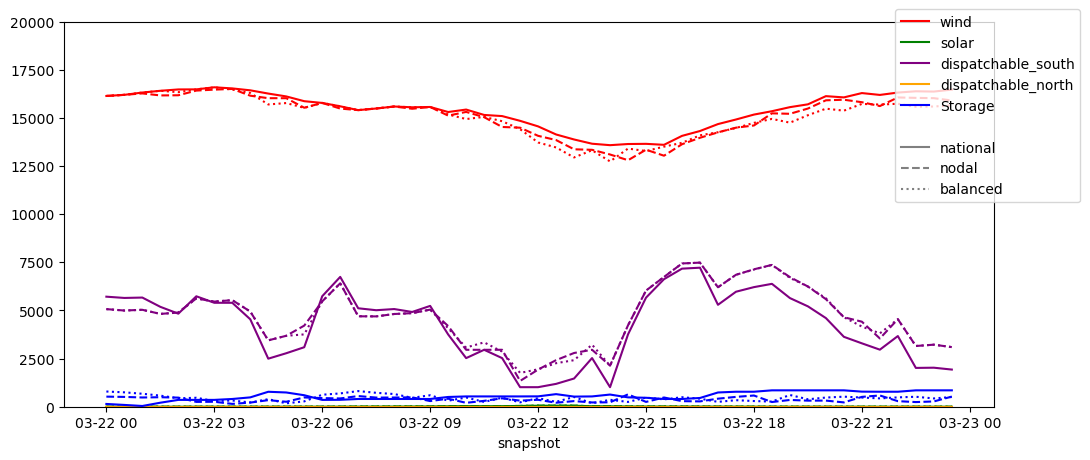

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

labels = []
handles = []

for plants, c, n in zip([
    wind,
    solar,
    dispatchable_south,
    dispatchable_north
    ], ['red', 'green', 'purple', 'orange'],
    ['wind', 'solar', 'dispatchable_south', 'dispatchable_north']):

    sns.lineplot(
        data=nat.generators_t.p[plants].sum(axis=1),
        ax=ax,
        color=c,
        )
    sns.lineplot(
        data=nod.generators_t.p[plants].sum(axis=1),
        ax=ax,
        color=c,
        linestyle='dashed',
        )
    sns.lineplot(
        data=bal.generators_t.p[plants].sum(axis=1),
        ax=ax,
        color=c,
        linestyle=':',
        )
    
    labels.append(n)
    handles.append(plt.Line2D([0], [0], color=c))

c = 'blue'
sns.lineplot(
    data=nat.storage_units_t.p[water].sum(axis=1),
    ax=ax,
    color=c,
    )
sns.lineplot(
    data=nod.storage_units_t.p[water].sum(axis=1),
    ax=ax,
    color=c,
    linestyle='dashed',
    )
sns.lineplot(
    data=bal.storage_units_t.p[water].sum(axis=1),
    ax=ax,
    color=c,
    linestyle=':',
    )
    
labels.append('Storage')
handles.append(plt.Line2D([0], [0], color=c))

labels.append('')
handles.append(plt.Line2D([0], [0], color='white'))

labels.append('national')
handles.append(plt.Line2D([0], [0], color='grey'))
labels.append('nodal')
handles.append(plt.Line2D([0], [0], color='grey', linestyle='dashed'))
labels.append('balanced')
handles.append(plt.Line2D([0], [0], color='grey', linestyle=':'))

ax.legend(
    handles, labels,
    loc='upper right', bbox_to_anchor=(1.1, 1.05))

ax.set_ylim(0, 20_000)

plt.show()

In [77]:
bidding_vol = []

for day in pd.date_range('2024-03-01', '2024-03-25', freq='d'):
    day = day.strftime('%Y-%m-%d')
    bidding_vol.append(get_bidding_volume(day=day))

INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, st

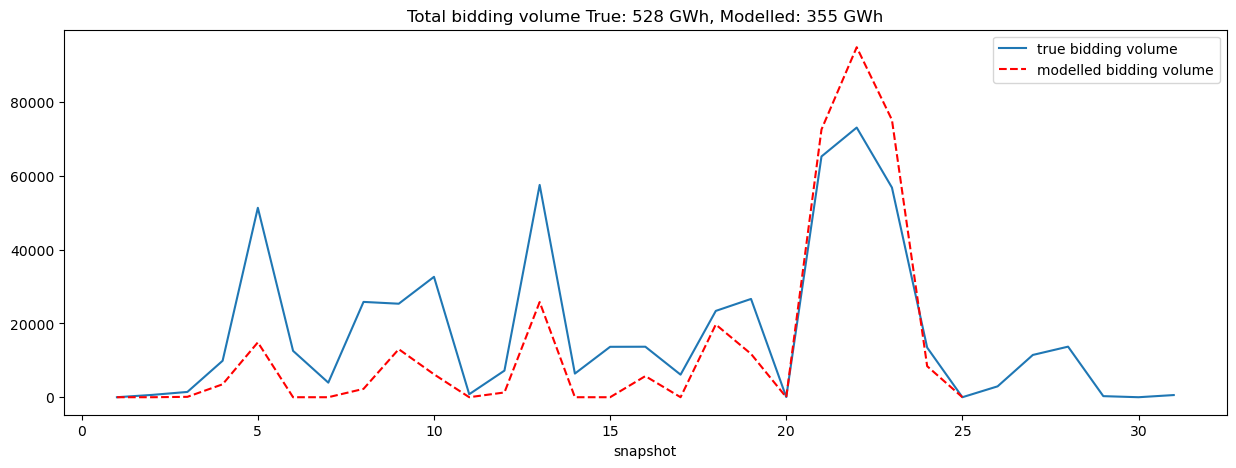

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

bids.replace(np.nan, 0).sum(axis=1).groupby(bids.index.day).sum().plot(ax=ax, label='true bidding volume')

(
    (b := pd.concat(bidding_vol))
    .groupby(b.index.day).sum()
    .plot(ax=ax, color='red', linestyle='dashed', label='modelled bidding volume')
)

b.index = pd.to_datetime(b.index, utc=True)

ax.set_title(
    (
        "Total bidding volume "
        f"True: {bids.replace(np.nan, 0).sum(axis=1).loc[b.index[0]:b.index[-1]].mul(1e-3).sum():.0f} GWh, "
        f"Modelled: {b.mul(1e-3).sum():.0f} GWh"
    )
)

plt.legend()

plt.show()

In [ ]:
import geopandas as gpd

zonal = gpd.read_file(Path.cwd().parent / 'data' / 'eso_zones.geojson').set_index('name')
zonal['centroid_lat'] = zonal.geometry.centroid.y
zonal.sort_values('centroid_lat', ascending=False, inplace=True)
zonal

,geometry,centroid_lat
name,,
GB0 Z1_1,"MULTIPOLYGON (((-1.60814 59.54735, -1.61042 59...",60.377480
GB0 Z1_3,"MULTIPOLYGON (((-3.34789 58.65204, -3.34057 58...",58.107875
GB0 Z1_2,"MULTIPOLYGON (((-7.38199 56.98753, -7.37352 56...",57.944564
GB0 Z2,"POLYGON ((-3.09422 57.67233, -3.07868 57.66942...",57.182664
GB0 Z1_4,"MULTIPOLYGON (((-6.16002 56.46955, -6.21247 56...",57.119940
GB0 Z3,"MULTIPOLYGON (((-5.00939 55.72932, -5.01618 55...",56.442002
GB0 Z4,"MULTIPOLYGON (((-5.11779 55.43976, -5.16356 55...",55.779896
GB0 Z5,"POLYGON ((-2.57681 56.28075, -2.57681 56.27778...",55.777926
GB0 Z6,"POLYGON ((-2.14293 55.91612, -2.13801 55.91462...",55.264882


In [2]:
import pypsa
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [3]:
buses = pypsa.Network(Path.cwd().parent / 'results' / '2024-03-22' / 'network.nc').buses

INFO:pypsa.io:Imported network network.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [14]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)

In [11]:
zones = gpd.read_file(
    Path.cwd().parent /
    'data' /
    'preprocessed' /
    'zonal_layout.geojson'
    ).set_index('name')

In [15]:
zones

,geometry
name,
Northern Scotland,"MULTIPOLYGON (((-5.96255 56.52611, -5.95214 56..."
Scotland Central Belt,"MULTIPOLYGON (((-6.06395 55.77338, -6.05455 55..."
Northern England,"POLYGON ((-1.76863 55.64191, -1.7565 55.63361,..."
Midlands,"MULTIPOLYGON (((-2.71756 52.12544, -3.02611 52..."
Southern Belt,"POLYGON ((-5.30933 51.87699, -5.3112 51.88021,..."
Southern England,"MULTIPOLYGON (((-6.29882 49.93549, -6.29223 49..."


In [ ]:
ss = bmus.loc[
    (bmus['lat'] != 'distributed') &
    (bmus['lat'] != 0)
]
bm_gpd = gpd.GeoDataFrame(ss[[]], geometry=gpd.points_from_xy(
    buses.loc[ss.bus, 'x'].values,
    buses.loc[ss.bus, 'y'].values,
    ),
    crs='EPSG:4326')
bm_gpd = bm_gpd.sjoin(zones, how='left')

In [ ]:
import seaborn as sns

grouped_bids = bids.replace(np.nan, 0).groupby(bids.index.day).sum().T
grouped_bids = (
    grouped_bids
    # .groupby(grouped_bids.index.map(lambda x: bm_gpd.loc[x, 'index_right']))
    .groupby(grouped_bids.index.map(lambda x: bm_gpd.loc[x, 'name']))
    .sum()
)

<Axes: >

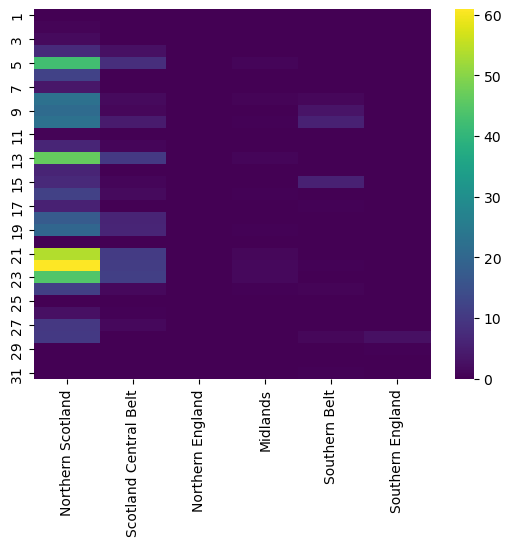

In [ ]:
sns.heatmap(grouped_bids.mul(1e-3).T[[
    'Northern Scotland',
    'Scotland Central Belt',
    'Northern England',
    'Midlands',
    'Southern Belt',
    'Southern England',
    ]], cmap='inferno')

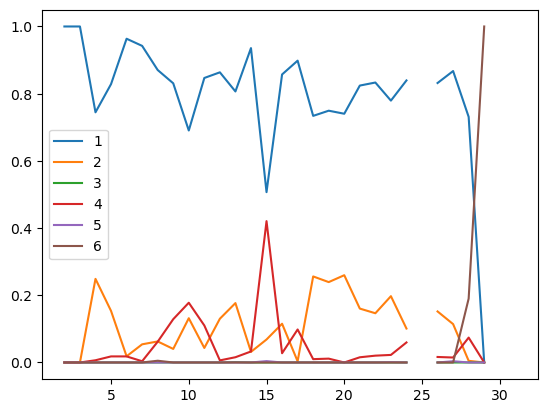

In [103]:
for i in grouped_bids.index:
    (grouped_bids.loc[i] / grouped_bids.sum()).plot(label=i)
plt.legend()

In [1]:
nod

NameError: name 'nod' is not defined

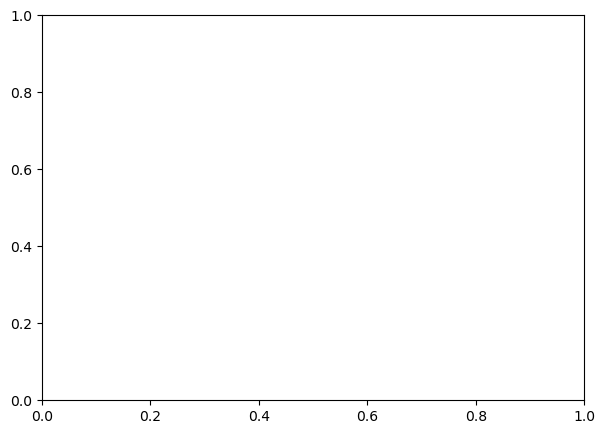

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))



plt.show()

In [51]:
natn.buses.loc[natn.buses.country != 'GB']

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country
Bus,,,,,,,,,,,,,
Belgium,380.0,,3.12,51.23,electricity,,1.0,0.0,inf,Slack,belgium_local_market,,Belgium
Denmark,380.0,,8.40,55.43,electricity,,1.0,0.0,inf,Slack,denmark_local_market,,Denmark
France,380.0,,-1.71,49.64,electricity,,1.0,0.0,inf,Slack,france_local_market,,France
Netherlands,380.0,,3.56,51.53,electricity,,1.0,0.0,inf,Slack,netherlands_local_market,,Netherlands
Norway,380.0,,5.50,59.02,electricity,,1.0,0.0,inf,Slack,norway_local_market,,Norway


In [40]:
ns.buses.loc[ns.buses.country != 'GB']

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,tags,under_construction,country,symbol,substation_lv,substation_off
Bus,,,,,,,,,,,,,,,,,,
Netherlands,1.0,,3.56,51.53,electricity,,1.0,0.0,inf,PQ,,,,NaN,Netherlands,,NaN,NaN
France,1.0,,-1.71,49.64,electricity,,1.0,0.0,inf,PQ,,,,NaN,France,,NaN,NaN
Belgium,1.0,,3.12,51.23,electricity,,1.0,0.0,inf,PQ,,,,NaN,Belgium,,NaN,NaN
Denmark,1.0,,8.40,55.43,electricity,,1.0,0.0,inf,PQ,,,,NaN,Denmark,,NaN,NaN
Norway,1.0,,5.50,59.02,electricity,,1.0,0.0,inf,PQ,,,,NaN,Norway,,NaN,NaN


In [37]:
ns.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,tags,under_construction,geometry,underground,underwater_fraction
Link,,,,,,,,,,,,,,,,,,,,,
8009,5896,5939,,DC,1.00,True,0,inf,2200.0,0.0,...,NaN,NaN,1.0,1.0,0.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""70191"", ""...",0.0,"LINESTRING(-3.18595885129092 53.213699479605,-...",0.0,0.979689
8708,6443,6448,,DC,1.00,True,0,inf,1200.0,0.0,...,NaN,NaN,1.0,1.0,0.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""115391"", ...",0.0,"LINESTRING(-3.45338156475634 58.4908032474467,...",0.0,0.583200
IFA1,France,4977,,interconnector,0.99,True,0,inf,2000.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
IFA2,France,4955,,interconnector,0.99,True,0,inf,2116.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
ElecLink,France,5269,,interconnector,0.99,True,0,inf,1277.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
